In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Own traffic projections

import terminal_optimization.visualisation as visualisation
import terminal_optimization.forecast      as forecast

def traffic_generator(nr_generations, start_year, simulation_window):
    
    ###################################################################################################
    # Traffic projections on which estimate is based
    ###################################################################################################

    # Import commodities from package
    maize   = forecast.bulk_commodities(**forecast.maize_data)
    soybean = forecast.bulk_commodities(**forecast.maize_data)
    wheat   = forecast.bulk_commodities(**forecast.wheat_data)

    # Maize - Probabilistic demand
    maize.historic = [828900,752700,774700,810000,769100,768100,763600,799000,793600,885400,870500,844600,852000,867700,970000,900000,900000,1010000,1030000,1060000,1065000,1070000,1100000,1150000]
    maize.rate     = 1.0336         # Average consumption growth in South Africa in the past 5 years
    maize.sigma    = 0.0374         # Standard deviation in consumption growth in South Africa in the past 5 years

    # If required number of traffic generations is even, one iteration is added in order to be able to identify the median
    if nr_generations % 2 == 0:
        nr_generations = nr_generations + 1 

    # Create traffic projections
    traffic_projections = []
    for iterations in range(nr_generations):
        maize.random_scenario(start_year, simulation_window, maize.historic, maize.rate, maize.sigma)
        traffic_projections.append(maize.demand)
    
    ###################################################################################################
    # Traffic scenario based on median present quantity of all projections
    ################################################################################################### 
    
    # Calculate the net present quantity of each projection
    project_WACC = 0.09
    WACC_factor = []
    for year in range (len(maize.historic)):
        WACC_factor.append(1.0)
    for year in range (simulation_window):
        WACC_factor.append(1/((1+project_WACC)**(year)))

    traffic_matrix = np.zeros(shape=(len(traffic_projections), 2))
    for i in range(len(traffic_projections)):
        traffic_matrix[i,0] = i
        present_value_volume = []
        for j in range(len(traffic_projections[i])):
            present_value_volume.append(traffic_projections[i][j]*WACC_factor[j])
        traffic_matrix[i,1] = int(np.sum(present_value_volume))

    df=pd.DataFrame(traffic_matrix, columns=['Iteration','NPQ'])

    # Select the median traffic projection in terms of present quantity
    median_iteration = df.loc[df['NPQ']==np.median(df['NPQ'])].index[0]
    traffic_scenario = traffic_projections[median_iteration] 
    maize.demand   = traffic_scenario 
    soybean.demand = [0]*len(maize.demand)
    wheat.demand   = [0]*len(maize.demand)
    commodities    = [maize, soybean, wheat]
    
    ###################################################################################################
    # Translate traffic projection into terminal calls 
    ################################################################################################### 
    
    # Import vessels from package
    handysize = forecast.vessel(**forecast.handysize_data)
    handymax  = forecast.vessel(**forecast.handymax_data)
    panamax   = forecast.vessel(**forecast.panamax_data)
    vessels = [handysize, handymax, panamax]
    
    # Calculate yearly calls
    vessels = forecast.vessel_call_calc(vessels, commodities, simulation_window)

    # Plot forecast
    fig = visualisation.scenario(traffic_projections, commodities)
    
    return vessels, commodities, fig, traffic_projections, traffic_scenario

In [3]:
nr_generations    = 10
start_year        = 2018
simulation_window = 20
vessels, commodities, fig, traffic_projections, traffic_scenario = traffic_generator(nr_generations, start_year, simulation_window)

years  = [commodities[0].years]
demand = [commodities[0].demand]
matrix = np.concatenate((years, demand),axis=0)
matrix = np.transpose(matrix)
data   = pd.DataFrame(matrix, columns=['Years', 'Sales'])

forecast_window = 2
hindcast_window = 4

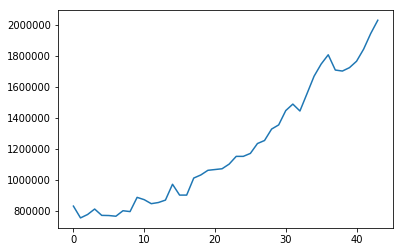

In [4]:
# This tutorial was found on https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

# We can see that the Shampoo Sales dataset has a clear trend.

# This suggests that the time series is not stationary and will 
# require differencing to make it stationary, at least a difference order of 1.

data['Sales'].plot()

C:\Python\lib\site-packages\ipykernel_launcher.py:10: FutureWarning:

'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.



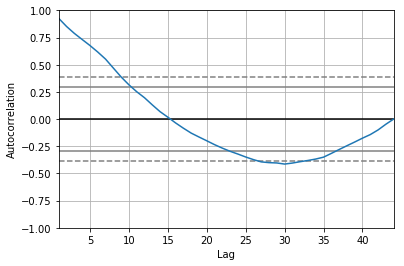

In [5]:
# Let’s also take a quick look at an autocorrelation plot of the time series. 
# The example below plots the autocorrelation for a large number of lags in the time series.
# The lag is the amount of historic data points that are used to forecast the next data point
# For more infor check https://www.youtube.com/watch?v=ZjaBn93YPWo from 6:00

# Running the example, we can see that there is a positive correlation with the first 10-to-12 lags that 
# is perhaps significant for the first 5 lags. A good starting point for the AR parameter of the model may be 5.

from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(data['Sales'])

In [6]:
from statsmodels.tsa.arima_model import ARIMA

# The parameters of the ARIMA model are defined as follows:

# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.

# fit model
model = ARIMA(data['Sales'], order=(hindcast_window,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   43
Model:                 ARIMA(4, 1, 0)   Log Likelihood                -526.279
Method:                       css-mle   S.D. of innovations          49916.000
Date:                Mon, 17 Dec 2018   AIC                           1064.558
Time:                        13:17:07   BIC                           1075.125
Sample:                             1   HQIC                          1068.455
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          2.793e+04   6216.578      4.492      0.000    1.57e+04    4.01e+04
ar.L1.D.Sales     0.0679      0.159      0.426      0.673      -0.245       0.380
ar.L2.D.Sales    -0.1417      0.162     

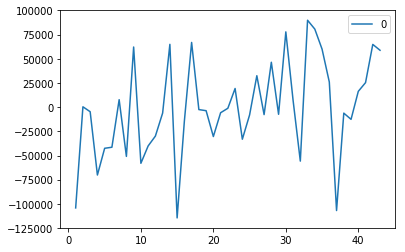

In [7]:
# First, we get a line plot of the residual errors, 
# suggesting that there may still be some trend information not captured by the model.

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()

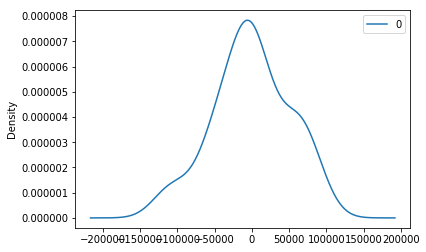

In [8]:
# Next, we get a density plot of the residual error values, suggesting the errors are Gaussian, 
# but may not be centered on zero.

residuals.plot(kind='kde')
plt.show()

In [9]:
# The distribution of the residual errors is displayed. 
# The results show that indeed there is a bias in the prediction (a non-zero mean in the residuals).

print(residuals.describe())

                   0
count      43.000000
mean    -1151.727689
std     50665.757850
min   -114470.268154
25%    -31736.061221
50%     -4672.534477
75%     29286.725132
max     89884.919857


In [10]:
# Now to apply a rolling forcast using the ARIMA model

# We can split the training dataset into train and test sets, 
# use the train set to fit the model, and generate a prediction for each element on the test set.

# We manually keep track of all observations in a list called history that is seeded with the training 
# data and to which new observations are appended each iteration.

X           = data['Sales'].values
size        = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history     = [x for x in train]

In [11]:
predictions = []
for t in range(len(test)):
    for i in range(forecast_window):
        if t == len(test)-1:
            break
        model = ARIMA(history, order=(hindcast_window,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        prediction = int(round(output[0][0]))       
        if i == 0:
            if t == 0:
                predictions.append(prediction)
            if t != 0:
                predictions[-1] = prediction
            history.append(prediction)
        else:
            predictions.append(prediction)
        
    observation = test[t]
    history[-1] = observation

Test Mean Squared Error: 609874643.667


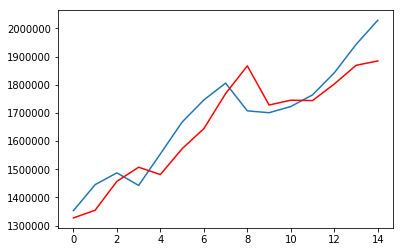

In [12]:
# We can also calculate a final mean squared error score (MSE) 
# for the predictions, providing a point of comparison for other ARIMA configurations.

# A line plot is created showing the expected values (blue) compared to the rolling forecast predictions (red). 
# We can see the values show some trend and are in the correct scale.

from sklearn.metrics import mean_squared_error

error = mean_squared_error(test, predictions)
print('Test Mean Squared Error: %.3f' % error)

# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.show()